# Evaluate Improved Earring Label

This notebook is intended for loading and exploring arbitrary pre-trained models

In [1]:
import sys
import os
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from pallets import images as I, datasets as DS, models as M, logging as L


## Settings

In [3]:
USE_GPU = True
LOG_LEVEL = 'INFO'
TEST_SIZE = 1000
EPOCHS = 500
LR = 1e-03
BATCH_SIZE = 32
LABELS_FILE = '../scripts/pallets_labels.json'

SAVE_NAME = 'fixed_earring'

In [4]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=True)

# Logging
logger = L.init_logger()


## Load Environment

In [5]:
# all_colors = I.get_punk_colors()
# mapper = DS.ColorOneHotMapper(all_colors)
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )
# torch.save(dataset, '../scripts/onehot_ds.pt')

dataset = torch.load('../scripts/onehot_ds.pt')

In [6]:
num_labels = len(dataset._labels[0])

train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
)
test_loader = DataLoader(
    dataset, batch_size=BATCH_SIZE, sampler=test_sampler,
)



# The Model

This model builds off the VAE using in the previous notebook with a final call to gumbel-softmax, allow backprop to nudge the output of the decoder into place

In [8]:

class NewVAE(M.vae.LabeledVAE):
    def forward(self, x, labels):
        x = self.encode(x)
        x = torch.cat([x, labels], dim=1)
        mu = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = torch.cat([z, labels], dim=1)
        z = self.decode(z)
        z = F.gumbel_softmax(z, tau=0.0001, hard=True)
        return z, mu, logvar


# Train Model

latent_dims = 32
model = M.vae.LabeledVAE(222, (64, 32), latent_dims, num_labels)

criterion = M.vae.Loss()


In [9]:
logger.info("starting model training")

train_losses, test_losses = M.vae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | starting model training
INFO | model: pallets.models.vae.LabeledVAE
INFO | criterion: pallets.models.vae.Loss
INFO | learn rate: 0.001
INFO | epochs: 500
INFO | epoch 1 (  0%) loss: 512372.218750
INFO | epoch 1 ( 35%) loss: 44241.654311
INFO | epoch 1 ( 70%) loss: 24574.455383
INFO | epoch 1 (100%) loss: 18623.582391
INFO | epoch 1 (test) loss: 3749.461891
INFO | epoch 2 (  0%) loss: 3935.225586
INFO | epoch 2 ( 35%) loss: 3843.043223
INFO | epoch 2 ( 70%) loss: 3817.367153
INFO | epoch 2 (100%) loss: 3798.272859
INFO | epoch 2 (test) loss: 3640.174006
INFO | epoch 3 (  0%) loss: 3824.031738
INFO | epoch 3 ( 35%) loss: 3746.195549
INFO | epoch 3 ( 70%) loss: 3709.903891
INFO | epoch 3 (100%) loss: 3594.863043
INFO | epoch 3 (test) loss: 3019.475098
INFO | epoch 4 (  0%) loss: 2971.120117
INFO | epoch 4 ( 35%) loss: 2993.946545
INFO | epoch 4 ( 70%) loss: 2931.582568
INFO | epoch 4 (100%) loss: 2874.846085
INFO | epoch 4 (test) loss: 2660.440397
INFO | epoch 5 (  0%) loss: 2450.0

## Test Model

In [7]:
# model, train_losses, test_losses = M.load(SAVE_NAME, device)


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


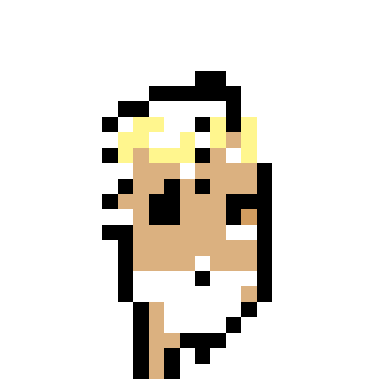

In [10]:

# Totally Random

z = torch.randn(1, latent_dims + num_labels).to(device)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)

decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


In [20]:
import json
ps_labels = json.load(open("../scripts/pallets_labels.json"))
label_keys = [k for k in ps_labels["0"].keys()]

_, test_labels = next(iter(train_loader))
features = test_labels[2]

enabled_features = [k for k,v in zip(label_keys, features) if v.item() == 1]
print(f"Features: {enabled_features}")


Features: ['female', 'greenEyeShadow', 'mohawkThin', 'blackLipstick', 'cigarette', 'earring']


torch.Size([1, 222, 24, 24])
torch.Size([222, 24, 24])
torch.Size([4, 24, 24])


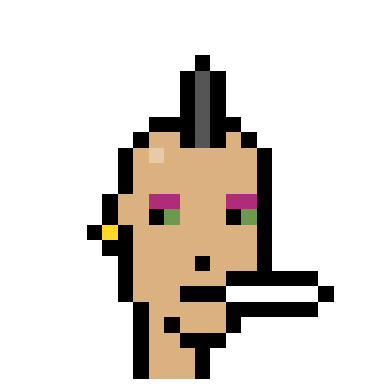

In [23]:
# Generate new image

# Random data for image side
z = torch.randn(1, latent_dims).to(device)

# Concat image with actual feature labels from dataset
z = torch.concat([z, features.unsqueeze(0)], dim=1)

with torch.no_grad():
    model.eval()
    generated_image = model.decode(z)
    print(generated_image.shape)


decoded_one_hot = generated_image[0]
print(decoded_one_hot.shape)
decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
print(decoded.shape)

plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


## Graph Losses

In [15]:
train_losses

[37247.16478106992,
 7596.545717063525,
 7189.726086339207,
 5749.69216940589,
 5216.3727542525485,
 4897.922866280197,
 4664.660748420878,
 4487.3528680463205,
 4352.383633228059,
 4280.238843985483,
 4229.370458291777,
 4199.9726376364415,
 4185.00863972116,
 4094.227905706311,
 3653.001795126191,
 3568.9280709341065,
 3512.7865972857103,
 3492.2842288186366,
 3483.310352081948,
 3472.0212406672485,
 3468.24237579995,
 3465.290386227006,
 3462.874898707613,
 3463.1828894648993,
 3459.9141585979055,
 3458.2715216021165,
 3459.4940702830645,
 3457.624555655405,
 3457.5800441444344,
 3466.2998497063386,
 3456.077897092129,
 3455.067614616232,
 3455.0298728131233,
 3455.0746698041335,
 3458.17229986529,
 3452.9902285312082,
 3453.62180669257,
 3455.173884614985,
 3457.0858452979555,
 3456.626434975482,
 3451.529353364985,
 3457.7710428440823,
 3452.777439415032,
 3447.360096383602,
 3442.8686298343305,
 3440.405972311683,
 3435.0913735247673,
 3374.6783349869097,
 3339.290826459303,
 331

In [16]:
test_losses

[7498.923782348633,
 7280.348011016846,
 6038.9501953125,
 5320.8807945251465,
 4977.242244720459,
 4694.782863616943,
 4515.201358795166,
 4359.214427947998,
 4262.709011077881,
 4206.360607147217,
 4176.746566772461,
 4152.390251159668,
 4139.913890838623,
 3689.507110595703,
 3644.4092502593994,
 3512.1454467773438,
 3481.3970279693604,
 3457.7513904571533,
 3447.5767211914062,
 3454.6688079833984,
 3441.8985843658447,
 3441.791723251343,
 3447.939769744873,
 3438.677017211914,
 3434.698329925537,
 3437.9996490478516,
 3428.62322807312,
 3429.5484008789062,
 3435.9146938323975,
 3434.169418334961,
 3445.6170196533203,
 3428.536787033081,
 3434.7639122009277,
 3427.3702354431152,
 3437.3732833862305,
 3422.218900680542,
 3431.3453311920166,
 3429.7171478271484,
 3450.7086429595947,
 3427.429599761963,
 3428.393898010254,
 3427.4721336364746,
 3421.193290710449,
 3416.504611968994,
 3417.9284896850586,
 3412.557945251465,
 3401.7389907836914,
 3305.1603775024414,
 3298.9713973999023,


<function matplotlib.pyplot.show(close=None, block=None)>

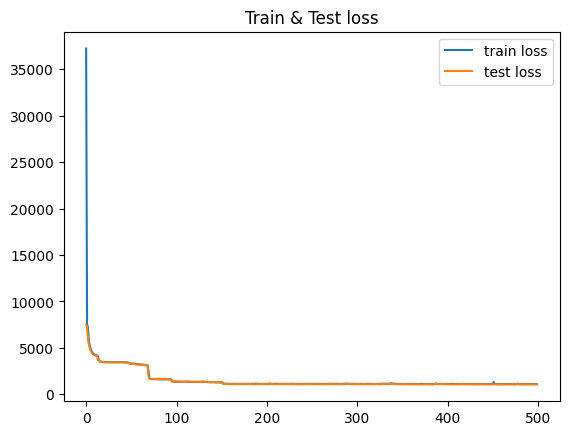

In [17]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show
